<a href="https://colab.research.google.com/github/FaridRasulov/NeuralODE/blob/master/Thesis_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture 
!pip install torchdiffeq 
!pip install pytorch_utils 
!pip install tqdm 
!pip install adversarial-robustness-toolbox 
!pip install kornia
!pip install foolbox

In [ ]:
import os
import argparse
import logging
import time
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, ConcatDataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from PIL import Image, ImageOps 
import os
import os.path
from os import path

import torch.nn.functional as F
import torch.optim as optim
from art.attacks.evasion import CarliniL2Method, ZooAttack, BoundaryAttack
from art.attacks.inference.membership_inference import MembershipInferenceBlackBox as MIBB
from art.estimators.classification import PyTorchClassifier
from art.utils import load_mnist 

import random
import itertools
from sklearn.model_selection import train_test_split  
from torchdiffeq import odeint_adjoint as odeint
from sklearn.utils import shuffle
from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.metrics import roc_curve, auc

In [ ]:
tol = 1e-3
nepochs = 2
data_aug = True # False
lr = 0.1
batch_size = 64
test_batch_size = 1000
save = './experiment1'
debug = 'store_true'
gpu = 0

In [ ]:
# !rm -r './GTSRB'

In [ ]:
%%capture
directory = r'./GTSRB'
if path.exists(directory)!=True:
  !wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
  !wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
  !unzip GTSRB_Final_Training_Images.zip
  !unzip GTSRB_Final_Test_Images.zip
#!find ./GTSRB/ -type f | sed -e 's/.*\.//' | sort | uniq -c | sort -n | grep -Ei '(ppm)$'

In [ ]:
img_orig = Image.open('./GTSRB/Final_Training/Images/00000/00000_00000.ppm')

In [ ]:
np.asarray(img_orig).dtype

dtype('uint8')

In [ ]:
# img_orig = np.asarray(Image.open('./GTSRB/Final_Training/Images/00000/00000_00000.ppm').resize((50,50),Image.ANTIALIAS))
# img_norm = (img - np.min(img))/(np.max(img) - np.min(img)) 
# img_int = (255*(img - np.min(img))/np.ptp(img)).astype(int) 

In [ ]:
directory = r'./GTSRB'
def get_dataset(directory, dataset, numclass, imSize=None,norm=True):
  x = list()
  y = list()
  directory = directory + dataset
  for subdir, dirs, files in os.walk(directory): 
    if subdir == directory: 
        continue 
    for filename in files: 
          filepath = subdir + os.sep + filename 
          if filename.endswith(".ppm"): 
              img = Image.open(filepath)
              if imSize:
                img = img.resize((imSize,imSize),Image.ANTIALIAS) 
              #img = img.convert('L') 
              img = np.asarray(img)
              if norm:
                img = (img - np.min(img))/(np.max(img) - np.min(img)) 
              x.append(img) 
          elif filename.endswith(".csv"): 
              data = np.genfromtxt(filepath, dtype=None, delimiter=',', skip_header=1, encoding='utf8') 
              y_tmp = np.zeros(shape=(data.shape[0],numclass), dtype=np.float32) 
              classID = int(data[0].split(';')[-1]) 
              y_tmp[:,classID] = 1 
              y.append(y_tmp) 
          else: 
            continue 

  x = np.asarray(x)
  #x = np.expand_dims(x, axis=3) 
  y = np.concatenate(y, axis=0, out=None)
  print(x.shape, y.shape) 
  y_lst=list() 
  for i in y: 
    y_lst.append(np.where(i == 1.)[0][0]) 
  y_set = set(y_lst) 
  print(len(y_set)) 
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
  x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42) 
  return (x_train, y_train), (x_val, y_val), (x_test, y_test), np.min(x), np.max(x) 

In [ ]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        shape = torch.prod(torch.tensor(x.shape[1:])).item()
        return x.view(-1, shape)

class ConcatConv2d(nn.Module):
    def __init__(self, dim_in, dim_out, ksize=3, stride=1, padding=0, dilation=1, groups=1, bias=True, transpose=False):
        super(ConcatConv2d, self).__init__()
        module = nn.ConvTranspose2d if transpose else nn.Conv2d
        self._layer = module(
            dim_in + 1, dim_out, kernel_size=ksize, stride=stride, padding=padding, dilation=dilation, groups=groups,
            bias=bias
        )

    def forward(self, t, x):
        tt = torch.ones_like(x[:, :1, :, :]) * t
        ttx = torch.cat([tt, x], 1)
        return self._layer(ttx)

class ODEfunc(nn.Module):

    def __init__(self, dim):
        super(ODEfunc, self).__init__()
        self.norm1 = nn.GroupNorm(min(32, dim), dim)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = ConcatConv2d(dim, dim, 3, 1, 1)
        self.norm2 = nn.GroupNorm(min(32, dim), dim)
        self.conv2 = ConcatConv2d(dim, dim, 3, 1, 1)
        #self.norm3 = nn.GroupNorm(min(32, dim), dim)
        self.nfe = 0

    def forward(self, t, x):
        self.nfe += 1
        out = self.norm1(x)
        out = self.relu(out)
        out = self.conv1(t, out)
        out = self.norm2(out)
        out = self.relu(out)
        out = self.conv2(t, out)
        #out = self.norm3(out)
        return out

class ODEBlock(nn.Module):

    def __init__(self, odefunc):
        super(ODEBlock, self).__init__()
        self.odefunc = odefunc
        self.integration_time = torch.tensor([0, 1]).float()

    def forward(self, x):
        self.integration_time = self.integration_time.type_as(x)
        out = odeint(self.odefunc, x, self.integration_time, rtol=tol, atol=tol)
        return out[1]

    @property
    def nfe(self):
        return self.odefunc.nfe

    @nfe.setter
    def nfe(self, value):
        self.odefunc.nfe = value

device = 'cuda'
dim=64

downsampling_layers = [
            nn.Conv2d(3, dim, 3, 1),
            nn.GroupNorm(min(32, dim), dim),
            nn.ReLU(inplace=True),
            nn.Conv2d(dim, dim, 4, 2, 1),
            nn.GroupNorm(min(32, dim), dim),
            nn.ReLU(inplace=True),
            nn.Conv2d(dim, dim, 4, 2, 1),
        ]

feature_layers = [ODEBlock(ODEfunc(dim))]
fc_layers = [nn.GroupNorm(min(32, dim), dim), nn.ReLU(inplace=True), nn.AdaptiveAvgPool2d((1, 1)), Flatten(), nn.Linear(dim, 43)]

In [ ]:
# Step 1: Load the MNIST dataset
#(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()
(x_train, y_train),(x_val, y_val),(x_test, y_test),min_pixel_value,max_pixel_value = get_dataset(directory,'/Final_Training',43,28)
print('Step 1: Load the MNIST dataset')
# Step 1a: Swap axes to PyTorch's NCHW format
x_train = np.swapaxes(x_train, 1, 3).astype(np.float32)
x_val = np.swapaxes(x_val, 1, 3).astype(np.float32)
x_test = np.swapaxes(x_test, 1, 3).astype(np.float32)
print("Step 1a: Swap axes to PyTorch's NCHW format")

(39209, 28, 28, 3) (39209, 43)
43
Step 1: Load the MNIST dataset
Step 1a: Swap axes to PyTorch's NCHW format


In [ ]:
np.max(x_train)

1.0

In [ ]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(31759, 3, 28, 28)
(3529, 3, 28, 28)
(3921, 3, 28, 28)


In [ ]:
def model_init_ode():
    model_ode = nn.DataParallel(nn.Sequential(*downsampling_layers, *feature_layers, *fc_layers).to(device))
    # Step 2a: Define the loss function and the optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer_ode = optim.SGD(model_ode.parameters(), lr=0.01)
    print('Step 2a: Define the loss function and the optimizer')
    # Step 3: Create the ART classifier
    classifier_ode = PyTorchClassifier(
        model=model_ode,
        loss=criterion,
        optimizer=optimizer_ode,
        input_shape=(3, 28, 28),
        nb_classes=43,
        #preprocessing_defences = FS_def
    )
    return classifier_ode
classifier_ode = model_init_ode()

Step 2a: Define the loss function and the optimizer


In [ ]:
classifier_ode.fit(adv_res_cw_train, y_train[:3000], batch_size=64, nb_epochs=5)

In [ ]:
# Step 7: Evaluate the ART classifier on adversarial test examples
predictions_ode = classifier_ode.predict(adv_res_cw_test)
accuracy_ode = np.sum(np.argmax(predictions_ode, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adv shuiffled test examples: {}%".format(accuracy_ode * 100))

Accuracy on adv shuiffled test examples: 90.7931650089263%


In [ ]:
acc, adv_train = attack(classifier_ode, x_train[1000:3000], y_train[1000:3000], confidence = 0, binary_search_steps=1, max_iter = 4, initial_const = 5)

In [ ]:
predictions = classifier_ode.predict(adv_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy trained on adv examples: {}%".format(accuracy * 100))

Accuracy trained on adv examples: 68.14588115276715%


In [ ]:
from art.defences.preprocessor import FeatureSqueezing as FS
FS_def = FS(clip_values=(0,1), bit_depth = 8, apply_fit = True, apply_predict = False)

In [ ]:
binary_search_steps =1
confidence = 0
max_iter = 4
initial_const = 5
batch_size=32

attack = CarliniL2Method(classifier_ode, confidence=confidence, binary_search_steps=binary_search_steps, max_iter=max_iter, initial_const=initial_const, batch_size=batch_size,verbose=False) 
adv = attack.generate(x = x_test, learning_rate = 0.01)
predictions = classifier_ode.predict(adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adv shuffled test examples: {}%".format(accuracy * 100))

Accuracy on adv shuffled test examples: 4.157102779903086%


In [ ]:
binary_search_steps = 1
confidence = 0
max_iter = 4
initial_const = 5
batch_size=32

attack = ZooAttack(classifier_ode, confidence=confidence, learning_rate = 0.1, max_iter=max_iter, binary_search_steps=binary_search_steps, initial_const=initial_const, batch_size=batch_size)
adv = attack.generate(x = x_test[:100])
predictions = classifier_ode.predict(adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test[:100], axis=1)) / len(y_test[:100]) 
print("Accuracy on adv test examples: {}%".format(accuracy * 100)) 

In [ ]:
targets = ((0,1),(1,0),(2,3),(3,2),(4,5),(5,4),(6,32),(7,8),(8,7),(9,10),(10,9),
            (11,30),(12,13),(13,15),(14,17),(15,13),(16,10),(17,14),(18,26),(19,20),(20,19),
              (21,31),(22,23),(23,22),(24,27),(25,28),(26,18),(27,24),(28,25),(29,31),(30,11),
                (31,21),(32,6),(33,34),(34,33),(35,36),(36,35),(37,35),(38,39),(39,38),(40,39),
                  (41,42),(42,41))

In [ ]:
targ = []
for t in targets:
  targ.append(t[1])
targ = np.array(targ)

labels = np.argmax(y_train, axis=1)
y_target_train = []

for l in labels:
  arr = np.zeros(43)
  arr[targ[l]]=1
  y_target_train.append(arr)
y_target_train = np.array(y_target_train)

In [ ]:
from art.attacks.poisoning import PoisoningAttackBackdoor as PAB
from art.attacks.evasion import FastGradientMethod as FGM

x_train_pab = x_train
fgm_attack = FGM(estimator=classifier_ode, eps=0.01)
attack = PAB(fgm_attack.generate)
adv, ys = attack.poison(x = x_train_pab, y = y_target_train)

In [ ]:
model_init_ode()
print('kuku')
classifier_ode.fit(adv, y_target_train, batch_size=32, nb_epochs=30)

Step 2a: Define the loss function and the optimizer
kuku


In [ ]:
predictions = classifier_ode.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adv shuffled test examples: {}%".format(accuracy * 100))

Accuracy on adv shuffled test examples: 0.0510073960724305%


In [ ]:
model_init_ode()
fgm_attack = FGM(estimator=classifier_ode, eps=0.2)
attack = PAB(fgm_attack.generate)
x_train_pab = x_train
adv, ys = attack.poison(x = x_train_pab, y = y_target_train)
predictions = classifier_ode.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
advs[ep]=[adv,ys,accuracy]
print("Accuracy on adv shuffled test examples: {}%".format(accuracy * 100))

In [ ]:
def attack(classifier, x_set, y_set, confidence = 0.0, binary_search_steps=1, max_iter = 4, initial_const = 0.01):
  attack = CarliniL2Method(classifier, confidence=confidence, binary_search_steps=binary_search_steps, max_iter=max_iter, initial_const=initial_const, batch_size=64) 
  adv = attack.generate(x = x_set, learning_rate = 0.1)
  predictions = classifier.predict(adv)
  accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_set, axis=1)) / len(y_set)
  return accuracy, adv

In [ ]:
indices = random.sample(range(x_test.shape[0]), 100)
x_test = np.swapaxes(x_test, 1, 3).astype(np.float32)
print('x_test', x_test.shape)

imgs = []
lbls = []

for i in indices:
  imgs.append(x_test[i])
  lbls.append(y_test[i])

imgs = np.array(imgs)
lbls = np.array(lbls)

imgs = np.swapaxes(imgs, 1, 3).astype(np.float32)
print('imgs', imgs.shape) 

x_test (3921, 28, 28, 3)
imgs (100, 3, 28, 28)


In [ ]:
params={'confidence':[0.0,0.1,0.5,1],'initial_const':[1,5,10,50,75,100]}
grid_search={}
for c,i in itertools.product(params['confidence'], params['initial_const']):
  accuracy, adv=attack(classifier_ode, imgs, lbls, confidence = c, binary_search_steps=1, max_iter=4, initial_const = i)
  grid_search[(c,i)]=(adv,accuracy)

In [ ]:
#grid_search = {k: v for k, v in sorted(grid_search.items(), key=lambda item: item[1][1], reverse=False)}
sorted_dic = {k: v for k, v in sorted(grid_search.items(), key=lambda item: item[1][1], reverse=False)}

In [ ]:
lst = random.sample(range(adv.shape[0]), 3)

In [ ]:
width = len(params['initial_const'])*2
height = len(params['confidence'])*3

In [ ]:
params = {'confidence':[0.0,0.05,0.1,0.5,1],'initial_const':[1,5,10,50,100]}
acc = {0.0:[],0.05:[],0.1:[],0.5:[],1:[]}
for c in params['confidence']:
  for i in params['initial_const']:
    accuracy = attack(classifier_for_shuffled, x_test, y_test, confidence = c, binary_search_steps=1, initial_const = i)
    acc[c].append(accuracy)

In [ ]:
inp = x_test[:1000]
lbl = y_test[:1000]

In [ ]:
max_iter = [1,2,4,8,16]
acc={'ode':[],'res':[]}
for i in max_iter:
  accuracy_ode, adv_ode = attack(classifier_res, inp, lbl, confidence = 0, binary_search_steps=1, max_iter=i, initial_const = 5)
  accuracy_res, adv_res = attack(classifier_res, inp, lbl, confidence = 0.1, binary_search_steps=1, max_iter=i, initial_const = 10)
  acc['ode'].append(accuracy_ode)
  acc['res'].append(accuracy_res)

In [ ]:
shuffled_train_set, shuffled_label_set = shuffle(np.concatenate((x_train, x_train_adv_shuffled), axis=0), np.concatenate((y_train, y_train), axis=0), random_state=0)
print(shuffled_train_set.shape, shuffled_label_set.shape)

In [ ]:
dim=32
device = 'cuda'

class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        shape = torch.prod(torch.tensor(x.shape[1:])).item()
        return x.view(-1, shape)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.gn1 = nn.GroupNorm(min(32, out_channels), out_channels)#nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.gn2 = nn.GroupNorm(min(32, out_channels), out_channels)#nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.gn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.gn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

# ResNet

downsampling_layers = [
            nn.Conv2d(3, dim, 3, 1),
            nn.GroupNorm(min(32, dim), dim),
            nn.ReLU(inplace=True),
            nn.Conv2d(dim, dim, 4, 2, 1),
            nn.GroupNorm(min(32, dim), dim),
            nn.ReLU(inplace=True),
            nn.Conv2d(dim, dim, 4, 2, 1),
        ]

fc_layers = [nn.GroupNorm(min(32, dim), dim), nn.ReLU(inplace=True), nn.AdaptiveAvgPool2d((1, 1)), Flatten(), nn.Linear(dim, 43)]

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=43):
        super(ResNet, self).__init__()
        self.in_channels = 32
        self.gn1 = nn.GroupNorm(min(32, self.in_channels), self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.RESBLOCKS = self.make_layer(block, self.in_channels, layers[0])
        
    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False), 
                nn.GroupNorm(min(32, self.in_channels), self.in_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.gn1(x)
        out = self.relu(out)
        out = self.RESBLOCKS(out)
        return out

resnet = ResNet(ResidualBlock, [6]).to(device)

In [ ]:
def model_init_res():
    model_res = nn.DataParallel(nn.Sequential(*downsampling_layers, resnet, *fc_layers).to(device))
    optimizer_res = optim.SGD(model_res.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()
    classifier_res = PyTorchClassifier(
        model=model_res,
        loss=criterion,
        optimizer=optimizer_res,
        input_shape=(3, 28, 28),
        nb_classes=43,
    )
    return classifier_res
classifier_res = model_init_res()

In [ ]:
classifier_res.fit(x_train, y_train, batch_size=32, nb_epochs=30)

In [ ]:
# Step 7: Evaluate the ART classifier on adversarial test examples
predictions_res = classifier_res.predict(x_test)
accuracy_res = np.sum(np.argmax(predictions_res, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adv shuffled test examples: {}%".format(accuracy_res * 100))

Accuracy on adv shuffled test examples: 98.29125223157358%


In [ ]:
acc, adv_res_cw_train = attack(classifier_res, x_train[:3000], y_train[:3000], confidence = 0.1, binary_search_steps=1, max_iter = 4, initial_const = 10)

C&W L_2: 100%|██████████| 47/47 [01:08<00:00,  1.47s/it]


In [ ]:
acc, adv_res_cw_test = attack(classifier_res, x_test, y_test, confidence = 0.1, binary_search_steps=1, max_iter = 4, initial_const = 10)

C&W L_2: 100%|██████████| 62/62 [01:31<00:00,  1.48s/it]


In [ ]:
# Step 7: Evaluate the ART classifier on adversarial test examples
predictions_res = classifier_res.predict(adv_res_test)
accuracy_res = np.sum(np.argmax(predictions_res, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adv shuffled test examples: {}%".format(accuracy_res * 100))

Accuracy on adv shuffled test examples: 7.778627901045651%


In [ ]:
zooattack = ZooAttack(classifier_res, confidence=0, learning_rate = 0.1, max_iter=4, binary_search_steps=1, initial_const=5, batch_size=32)
adv_res_zoo_test = zooattack.generate(x = x_test[:100], y = y_test[:100])

In [ ]:
binary_search_steps = 1
confidence = 0.1
max_iter = 4
initial_const = 10
batch_size = 32

attack = CarliniL2Method(classifier_res, confidence=confidence, binary_search_steps=binary_search_steps, max_iter=max_iter, initial_const=initial_const, batch_size=batch_size,verbose=False) 
adv = attack.generate(x = x_test, learning_rate = 0.01)
predictions = classifier_res.predict(adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adv shuffled test examples: {}%".format(accuracy * 100))

Accuracy on adv shuffled test examples: 2.5248661055853097%


In [ ]:
binary_search_steps = 1
confidence = 0.1
max_iter = 4
initial_const = 10
batch_size=32

attack = ZooAttack(classifier_res, confidence=confidence, learning_rate = 0.1, max_iter=max_iter, binary_search_steps=binary_search_steps, initial_const=initial_const, batch_size=batch_size)
adv = attack.generate(x = x_test[:300])
predictions = classifier_res.predict(adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test[:300], axis=1)) / len(y_test[:300]) 
print("Accuracy on adv test examples: {}%".format(accuracy * 100)) 

In [ ]:
targets = ((0,1),(1,0),(2,3),(3,2),(4,5),(5,4),(6,32),(7,8),(8,7),(9,10),(10,9),
            (11,30),(12,13),(13,15),(14,17),(15,13),(16,10),(17,14),(18,26),(19,20),(20,19),
              (21,31),(22,23),(23,22),(24,27),(25,28),(26,18),(27,24),(28,25),(29,31),(30,11),
                (31,21),(32,6),(33,34),(34,33),(35,36),(36,35),(37,35),(38,39),(39,38),(40,39),
                  (41,42),(42,41))

In [ ]:
targ = []
for t in targets:
  targ.append(t[1])
targ = np.array(targ)

labels = np.argmax(y_test, axis=1)
y_target = []

for l in labels:
  arr = np.zeros(43)
  arr[targ[l]]=1
  y_target.append(arr)
y_target = np.array(y_target)

In [ ]:
idx = random.sample(range(x_test.shape[0]), 300)
inp = x_test[idx]
lbl = y_test[idx]
lbl_trg = y_target[idx]

In [ ]:
attack=BoundaryAttack(classifier_res, targeted=True, max_iter=16, verbose=False)
adv=attack.generate(x = inp, y = lbl_trg)

In [ ]:
predictions = classifier_res.predict(adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(lbl, axis=1)) / len(lbl)
print("Accuracy on adv test examples: {}%".format(accuracy * 100)) 

Accuracy on adv test examples: 30.333333333333336%


In [ ]:
targ = []
for t in targets:
  targ.append(t[1])
targ = np.array(targ)

labels = np.argmax(y_train, axis=1)
y_target_train = []

for l in labels:
  arr = np.zeros(43)
  arr[targ[l]]=1
  y_target_train.append(arr)
y_target_train = np.array(y_target_train)

In [ ]:
from art.attacks.poisoning import PoisoningAttackBackdoor as PAB
from art.attacks.evasion import FastGradientMethod as FGM

x_train_pab = x_train
fgm_attack = FGM(estimator=classifier_res, eps=0.01)
attack = PAB(fgm_attack.generate)
adv, ys = attack.poison(x = x_train_pab, y = y_target_train)
model_init_res()
print('kuku')
classifier_res.fit(adv, y_target_train, batch_size=32, nb_epochs=30)
predictions = classifier_res.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adv shuffled test examples: {}%".format(accuracy * 100))

kuku
Accuracy on adv shuffled test examples: 0.17852588625350677%


In [ ]:
# adv_ode = {}
# max_iter = [1,2,4,8,16,32,64,128]
# for i in max_iter:
#   attack=BoundaryAttack(classifier_ode, targeted=True, max_iter=i, verbose=True)
#   adv_ode[i] = [attack.generate(x = inp, y = lbl_trg)]
#   predictions = classifier_ode.predict(adv_ode[i][0])
#   accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(lbl, axis=1)) / len(lbl)
#   adv_ode[i].append(accuracy)
#   print(i, "Accuracy on adv shuffled test examples: {}%".format(accuracy * 100))
######################################################################################
######################################################################################
# Boundary attack: 100%|██████████| 100/100 [04:47<00:00,  2.87s/it]
# 1 Accuracy on adv shuffled test examples: 38.0%
# Boundary attack: 100%|██████████| 100/100 [05:45<00:00,  3.46s/it]
# 2 Accuracy on adv shuffled test examples: 45.0%
# Boundary attack: 100%|██████████| 100/100 [08:21<00:00,  5.02s/it]
# 4 Accuracy on adv shuffled test examples: 49.0%
# Boundary attack: 100%|██████████| 100/100 [13:54<00:00,  8.34s/it]
# 8 Accuracy on adv shuffled test examples: 35.0%
# Boundary attack: 100%|██████████| 100/100 [19:49<00:00, 11.89s/it]
# 16 Accuracy on adv shuffled test examples: 46.0%
# Boundary attack: 100%|██████████| 100/100 [35:08<00:00, 21.09s/it]
# 32 Accuracy on adv shuffled test examples: 42.0%
# Boundary attack: 100%|██████████| 100/100 [59:03<00:00, 35.43s/it]
# 64 Accuracy on adv shuffled test examples: 46.0%
# Boundary attack: 100%|██████████| 100/100 [1:53:12<00:00, 67.92s/it]
# 128 Accuracy on adv shuffled test examples: 59.0%

Boundary attack: 100%|██████████| 100/100 [04:47<00:00,  2.87s/it]


1 Accuracy on adv shuffled test examples: 38.0%


Boundary attack: 100%|██████████| 100/100 [05:45<00:00,  3.46s/it]


2 Accuracy on adv shuffled test examples: 45.0%


Boundary attack: 100%|██████████| 100/100 [08:21<00:00,  5.02s/it]


4 Accuracy on adv shuffled test examples: 49.0%


Boundary attack: 100%|██████████| 100/100 [13:54<00:00,  8.34s/it]


8 Accuracy on adv shuffled test examples: 35.0%


Boundary attack: 100%|██████████| 100/100 [19:49<00:00, 11.89s/it]


16 Accuracy on adv shuffled test examples: 46.0%


Boundary attack: 100%|██████████| 100/100 [35:08<00:00, 21.09s/it]


32 Accuracy on adv shuffled test examples: 42.0%


Boundary attack: 100%|██████████| 100/100 [59:03<00:00, 35.43s/it]


64 Accuracy on adv shuffled test examples: 46.0%


Boundary attack: 100%|██████████| 100/100 [1:53:12<00:00, 67.92s/it]


128 Accuracy on adv shuffled test examples: 59.0%


In [ ]:
adv_res = {}
max_iter = [1,2,4,8,16,32,64,128]
for i in max_iter:
  attack=BoundaryAttack(classifier_res, targeted=True, max_iter=i, verbose=True)
  adv_res[i] = [attack.generate(x = inp, y = lbl_trg)]
  predictions = classifier_res.predict(adv_res[i][0])
  accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(lbl, axis=1)) / len(lbl)
  adv_res[i].append(accuracy)
  print(i, "Accuracy on adv shuffled test examples: {}%".format(accuracy * 100)) 

Boundary attack: 100%|██████████| 100/100 [00:23<00:00,  4.18it/s]


1 Accuracy on adv shuffled test examples: 30.0%


Boundary attack: 100%|██████████| 100/100 [00:31<00:00,  3.19it/s]


2 Accuracy on adv shuffled test examples: 23.0%


Boundary attack: 100%|██████████| 100/100 [00:45<00:00,  2.19it/s]


4 Accuracy on adv shuffled test examples: 28.999999999999996%


Boundary attack: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


8 Accuracy on adv shuffled test examples: 30.0%


Boundary attack: 100%|██████████| 100/100 [02:09<00:00,  1.29s/it]


16 Accuracy on adv shuffled test examples: 20.0%


Boundary attack: 100%|██████████| 100/100 [03:35<00:00,  2.15s/it]


32 Accuracy on adv shuffled test examples: 24.0%


Boundary attack: 100%|██████████| 100/100 [05:49<00:00,  3.50s/it]


64 Accuracy on adv shuffled test examples: 34.0%


Boundary attack: 100%|██████████| 100/100 [11:29<00:00,  6.89s/it]


128 Accuracy on adv shuffled test examples: 32.0%


In [ ]:
import pickle 

# SAVE
with open("adv_res.pkl", "wb") as pkl_handle:
	pickle.dump(adv_res, pkl_handle)

# LOAD
# with open("adv_ode.pkl", "rb") as pkl_handle:
# 	output = pickle.load(adv_ode)

In [ ]:
with open("adv_ode.pkl", "rb") as pkl_handle:
   	adv_ode = pickle.load(pkl_handle)

In [ ]:
for en,i in enumerate(idx):
    if en%10==0:print()
    if adv_ode[8][0][en].all()==x_test[i].all():
          print(en,end=' ')


1 7 9 
10 15 16 17 18 19 
20 26 28 29 
31 32 34 36 37 
43 
51 52 54 55 
61 62 68 69 
73 75 79 
80 83 85 86 
92 94 95 96 

In [ ]:
predictions = classifier_ode.predict(adv_ode[8][0])
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(lbl, axis=1)) / len(lbl)
print("Accuracy on adv shuffled test examples: {}%".format(accuracy * 100))

Accuracy on adv shuffled test examples: 35.0%


In [ ]:
ba_acc_ode

[0.28, 0.35, 0.39, 0.24999999999999997, 0.36, 0.31999999999999995, 0.36, 0.49]

In [ ]:
for i in range(len(ba_acc_ode)):
  ba_acc_ode[i]=ba_acc_ode[i]-0.1

In [ ]:
ba_acc_ode=[]
ba_acc_res=[]
max_iter=[1,2,4,8,16,32,64,128]
for i in max_iter:
  ba_acc_ode.append(adv_ode[i][1])
  ba_acc_res.append(adv_res[i][1])

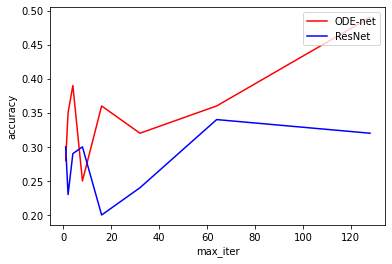

In [ ]:
import matplotlib.pyplot as plt
plt.plot(max_iter,ba_acc_ode,'r', label="ODE-net")
plt.plot(max_iter,ba_acc_res,'b', label="ResNet")
plt.xlabel('max_iter')
plt.ylabel('accuracy')
plt.legend(loc='upper right')
plt.savefig('BAmaxIterPlot.png')
plt.show()

In [ ]:
indexes = [np.where(np.argmax(y_test, axis=1)==item)[0][0] for item in range(43)]

In [ ]:
targets = ((0,1),(1,0),(2,3),(3,2),(4,5),(5,4),(6,32),(7,8),(8,7),(9,10),(10,9),
            (11,30),(12,13),(13,15),(14,17),(15,13),(16,10),(17,14),(18,26),(19,20),(20,19),
              (21,31),(22,23),(23,22),(24,27),(25,28),(26,18),(27,24),(28,25),(29,31),(30,11),
                (31,21),(32,6),(33,34),(34,33),(35,36),(36,35),(37,35),(38,39),(39,38),(40,39),
                  (41,42),(42,41))

In [ ]:
labels_targ = np.argmax(y_target, axis=1)

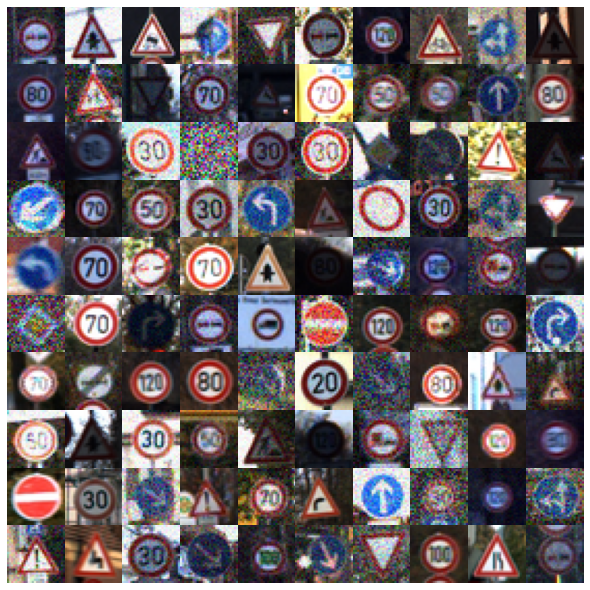

In [ ]:
import random
import itertools
import matplotlib.pyplot as plt
from PIL import Image

width = 10
height = 10
images = adv[64][0]

fig,ax = plt.subplots(height,width,figsize=(width*4,height*4),squeeze=False )      

h = 0
for en in range(width*height):
  w = en%width
  if en in range(width,width*height,width):
    h+=1
  img = np.swapaxes(images[[en]], 1, 3).astype(np.float32)
  ax[h][w].imshow(img.reshape(28,28,3))
  ax[h][w].axis('off')

fig.tight_layout(h_pad=0, w_pad=0.1, rect=None)  
fig.subplots_adjust(left=0, bottom=0, right=0.2, top=0.2, wspace=0, hspace=0)    
fig.show()

In [ ]:
# Step 1: Load the MNIST dataset
#(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()
(x_train, y_train),(x_val, y_val),(x_test, y_test),min_pixel_value,max_pixel_value = get_dataset(directory,'/Final_Training',43,28)
print('Step 1: Load the MNIST dataset')
# Step 1a: Swap axes to PyTorch's NCHW format
x_train = np.swapaxes(x_train, 1, 3).astype(np.float32)
x_val = np.swapaxes(x_val, 1, 3).astype(np.float32)
x_test = np.swapaxes(x_test, 1, 3).astype(np.float32)
print("Step 1a: Swap axes to PyTorch's NCHW format")

(39209, 28, 28, 3) (39209, 43)
43
Step 1: Load the MNIST dataset
Step 1a: Swap axes to PyTorch's NCHW format


In [ ]:
indices = random.sample(range(x_test.shape[0]), 1000)
x_test = np.swapaxes(x_test, 1, 3).astype(np.float32)
print('x_test', x_test.shape)

imgs = []
lbls = []

for i in indices:
  imgs.append(x_test[i])
  lbls.append(y_test[i])

imgs = np.array(imgs)
lbls = np.array(lbls)

imgs = np.swapaxes(imgs, 1, 3).astype(np.float32)
print('imgs', imgs.shape) 

In [ ]:
params={'confidence':[0.0,0.1,0.5,1],'initial_const':[1,5,10,50,75,100]}
grid_search={}
for c,i in itertools.product(params['confidence'], params['initial_const']):
  accuracy, adv=attack(classifier_res, imgs, lbls, confidence = c, binary_search_steps=1, max_iter=4, initial_const = i)
  grid_search[(c,i)]=(adv,accuracy)

In [ ]:
#grid_search = {k: v for k, v in sorted(grid_search.items(), key=lambda item: item[1][1], reverse=False)}
sorted_dic = {k: v for k, v in sorted(grid_search.items(), key=lambda item: item[1][1], reverse=False)}

In [ ]:
for en,i in enumerate(sorted_dic.keys()):
  print(en+1,i, sorted_dic[i][1])

In [ ]:
for en,i in enumerate(sorted_dic.keys()):
  print(en+1,i, sorted_dic[i][1])

In [ ]:
class MyDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = torch.argmax(torch.LongTensor(targets), dim=1)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        return x, y

    def __len__(self):
        return len(self.data)

trainset = MyDataset(x_train, y_train)
train_loader = DataLoader(trainset, batch_size=32)
valset = MyDataset(x_val, y_val)
val_loader = DataLoader(valset, batch_size=32)
testset = MyDataset(x_test, y_test)
test_loader = DataLoader(testset, batch_size=32)

In [ ]:
import numpy as np
from sklearn import metrics
y = np.array([1, 1, 2, 2])
scores = np.array([0.1, 0.4, 0.35, 0.8])
fpr, tpr, thresholds = metrics.roc_curve(y, scores, pos_label=2)

In [ ]:
model_res = classifier_res.model
optimizer_res = optim.SGD(model_res.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Let's create 10 RGB images of size 128x128 and ten labels {0, 1}
dataset = MyDataset(x_train, y_train)
dataloader = DataLoader(dataset, batch_size=32)

for epoch in range(5):  #loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer_res.zero_grad()
        outputs = model_res(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_res.step()
        running_loss += loss.item()
        if i % 33 == 32:    
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
# print('Finished Training')# Step 7: Evaluate the ART classifier on adversarial test examples
# predictions_res = classifier_res.predict(x_test)
# accuracy_res = np.sum(np.argmax(predictions_res, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
# print("Accuracy on adv shuffled test examples: {}%".format(accuracy_res * 100))

In [ ]:
x_test.shape

(3921, 3, 28, 28)

In [ ]:
testset = MyDataset(x_test, y_test)
testloader = DataLoader(testset, batch_size=32)

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_res(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
   
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 48 %


In [ ]:
import torchvision
from tqdm import tqdm

batch_size = 32

model = classifier_ode.model
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

def train(model, epoch, train_loader):
    num_items = 0
    train_losses = []
    model.train()
    criterion = nn.CrossEntropyLoss()
    print('Epoch: {}'.format(epoch), end=' ')
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.cuda()
        target = target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_losses += [loss.item()]
        num_items += data.shape[0]
    print('Train loss: {:.5f}'.format(np.mean(train_losses)), end = ' ')
    return np.mean(train_losses)

def val(model, val_loader):
    accuracy = 0.0
    num_items = 0
    val_losses = []

    model.eval()
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.cuda()
            target = target.cuda()
            output = model(data)
            loss = criterion(output, target)
            val_losses += [loss.item()]
            accuracy += torch.sum(torch.argmax(output, dim=1) == target).item()
            num_items += data.shape[0]
    accuracy = accuracy * 100 / num_items
    print('Val loss: {:.5f}'.format(np.mean(val_losses)),"Val Accuracy: {:.3f}%".format(accuracy), end = ' ')
    return [np.mean(val_losses), accuracy]

def test(model, test_loader):
    accuracy = 0.0
    num_items = 0
    test_losses = []

    model.eval()
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data = data.cuda()
            target = target.cuda()
            output = model(data)
            loss = criterion(output, target)
            test_losses += [loss.item()]
            accuracy += torch.sum(torch.argmax(output, dim=1) == target).item()
            num_items += data.shape[0]
    accuracy = accuracy * 100 / num_items
    print('Test loss: {:.5f}'.format(np.mean(test_losses)),"Test Accuracy: {:.3f}%".format(accuracy))
    return [np.mean(test_losses), accuracy]

test(model,test_loader)
evaluations = {}
#n_epochs = 10
for epoch in range(31, 41):
    evaluations[epoch] = [train(model,epoch,train_loader)]
    evaluations[epoch].extend(val(model,val_loader))
    evaluations[epoch].extend(test(model,test_loader))

Test loss: 0.03387 Test Accuracy: 99.362%
Epoch: 31 Train loss: 0.00692 Val loss: 0.03125 Val Accuracy: 99.518% Test loss: 0.03326 Test Accuracy: 99.388%
Epoch: 32 Train loss: 0.00633 Val loss: 0.03159 Val Accuracy: 99.547% Test loss: 0.03395 Test Accuracy: 99.337%
Epoch: 33 Train loss: 0.00582 Val loss: 0.03141 Val Accuracy: 99.490% Test loss: 0.03286 Test Accuracy: 99.388%
Epoch: 34 Train loss: 0.00551 Val loss: 0.03021 Val Accuracy: 99.433% Test loss: 0.03976 Test Accuracy: 99.311%
Epoch: 35 Train loss: 0.00522 Val loss: 0.03161 Val Accuracy: 99.462% Test loss: 0.03526 Test Accuracy: 99.337%
Epoch: 36 Train loss: 0.00488 Val loss: 0.03143 Val Accuracy: 99.462% Test loss: 0.03494 Test Accuracy: 99.337%
Epoch: 37 Train loss: 0.00461 Val loss: 0.03183 Val Accuracy: 99.433% Test loss: 0.03412 Test Accuracy: 99.388%
Epoch: 38 Train loss: 0.00433 Val loss: 0.03386 Val Accuracy: 99.405% Test loss: 0.03391 Test Accuracy: 99.388%
Epoch: 39 Train loss: 0.00403 Val loss: 0.03055 Val Accuracy: 

In [ ]:
train_loss_res = [evaluations[ep][0] for ep in evaluations]
val_loss_res = [evaluations[ep][1] for ep in evaluations]
val_acc_res = [evaluations[ep][2] for ep in evaluations]
test_loss_res = [evaluations[ep][3] for ep in evaluations]
test_acc_res = [evaluations[ep][4] for ep in evaluations]

In [ ]:
train_loss_ode_tmp = [evaluations[ep][0] for ep in evaluations]
val_loss_ode_tmp = [evaluations[ep][1] for ep in evaluations]
val_acc_ode_tmp = [evaluations[ep][2] for ep in evaluations]
test_loss_ode_tmp = [evaluations[ep][3] for ep in evaluations]
test_acc_ode_tmp = [evaluations[ep][4] for ep in evaluations]
################################################################
train_loss_ode = train_loss_ode.extend(train_loss_ode_tmp)
val_loss_ode = val_loss_ode.extend(val_loss_ode_tmp)
val_acc_ode = val_acc_ode.extend(val_acc_ode_tmp)
test_loss_ode = test_loss_ode.extend(test_loss_ode_tmp)
test_acc_ode = test_acc_ode.extend(test_acc_ode_tmp)

In [ ]:
train_loss_ode = [evaluations[ep][0] for ep in evaluations]
val_loss_ode = [evaluations[ep][1] for ep in evaluations]
val_acc_ode = [evaluations[ep][2] for ep in evaluations]
test_loss_ode = [evaluations[ep][3] for ep in evaluations]
test_acc_ode = [evaluations[ep][4] for ep in evaluations]

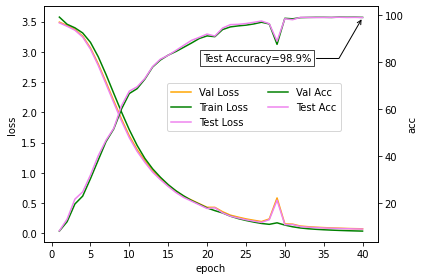

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Create some mock data
t = range(1, 41)

train_loss = train_loss_res
val_loss = val_loss_res
val_acc = val_acc_res
test_loss = test_loss_res
test_acc = test_acc_res

def annot_max(x,y, ax=None):
    xmax = x[-1]
    ymax = y[-1]
    text= "Test Accuracy={:.1f}%".format(ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.8,0.8), **kw)


fig, ax1 = plt.subplots()

ax1.set_xlabel('epoch')
ax1.set_ylabel('loss', color='black')
ax1.plot(t, val_loss, color='orange', label = 'Val Loss')
ax1.plot(t, train_loss, color='green', label = 'Train Loss')
ax1.plot(t, test_loss, color='violet', label = 'Test Loss')
ax1.tick_params(axis='y', labelcolor='black')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('acc', color='black')  # we already handled the x-label with ax1
ax2.plot(t, val_acc, color='green', label = 'Val Acc')
ax2.plot(t, test_acc, color='violet', label = 'Test Acc')
annot_max(t,test_acc, ax=None)
ax2.tick_params(axis='y', labelcolor='black')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.legend(['Val Loss','Train Loss','Test Loss','Val Acc','Test Acc'],loc="lower right",ncol=2,bbox_to_anchor=(0.8, 0.5))
plt.savefig('res_evals.png')
plt.show()

In [ ]:
from art.attacks.poisoning import PoisoningAttackBackdoor as PAB
from art.attacks.evasion import FastGradientMethod as FGM

In [ ]:

fgm_attack = FGM(estimator=classifier_res, eps=0.2)

In [ ]:
epsilon = [0.01,0.1,0.25,0.5]
advs={}
for ep in epsilon:
  model_init_ode()
  fgm_attack = FGM(estimator=classifier_ode, eps=0.01)
  attack = PAB(fgm_attack.generate)
  x_train_pab = x_train
  adv, ys = attack.poison(x = x_train_pab, y = y_target_train)
  predictions = classifier_ode.predict(x_test)
  accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
  advs[ep]=[adv,ys,accuracy]
  print("Accuracy on adv shuffled test examples: {}%".format(accuracy * 100))

In [ ]:
x_test_adv = attack.poison(x = x_test, y = np.random.shuffle)

In [ ]:
for en,i in enumerate(idx):
    if en%10==0:print()
    if x_test_adv[0][en].all()==x_test[i].all():
          print(en,end=' ')


2 8 
11 15 16 17 
21 22 26 
30 32 33 34 39 
41 
54 55 56 
63 64 65 67 
79 
84 85 88 
99 

In [ ]:
predictions = classifier_res.predict(inp)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(lbl, axis=1)) / len(lbl)
print("Accuracy on adv shuffled test examples: {}%".format(accuracy * 100))

Accuracy on adv shuffled test examples: 2.0%
